In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import pywt
import tqdm

In [3]:
df = pd.read_csv("../household_data_1min_singleindex.csv", parse_dates=["utc_timestamp"])

/tmp/ipykernel_3008105/1205812310.py:1: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../household_data_1min_singleindex.csv", parse_dates=["utc_timestamp"])


In [4]:
columns = [col for col in df.columns.tolist() if "DE_KN_residential4" in col]

In [5]:
columns

['DE_KN_residential4_dishwasher',
 'DE_KN_residential4_ev',
 'DE_KN_residential4_freezer',
 'DE_KN_residential4_grid_export',
 'DE_KN_residential4_grid_import',
 'DE_KN_residential4_heat_pump',
 'DE_KN_residential4_pv',
 'DE_KN_residential4_refrigerator',
 'DE_KN_residential4_washing_machine']

In [6]:
len("DE_KN_residential1")

18

In [25]:
df_clean = (df[columns + ["utc_timestamp"]]
    .set_index("utc_timestamp")
    .sort_index()
    .to_period()
    .ffill()
    .dropna(how="all")
    .fillna(0)
    .diff(1)
    .dropna()
    .assign(
        energy_generated=lambda x: x[['DE_KN_residential4_pv', 'DE_KN_residential4_grid_import']].sum(axis=1)
    )
).iloc[:40_000]

/tmp/ipykernel_3008105/83181512.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .to_period()


In [26]:
df_clean["DE_KN_residential4_heat_pump"]

utc_timestamp
2015-10-10 16:36    0.000
2015-10-10 16:37    0.000
2015-10-10 16:38    0.000
2015-10-10 16:39    0.002
2015-10-10 16:40    0.003
                    ...  
2015-11-07 11:11    0.000
2015-11-07 11:12    0.000
2015-11-07 11:13    0.000
2015-11-07 11:14    0.000
2015-11-07 11:15    0.000
Freq: T, Name: DE_KN_residential4_heat_pump, Length: 40000, dtype: float64

In [27]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [45]:
def calculate_wavelet_features(data, level):
    """Calculate wavelet features based on [1].
    Args:
        data
            Data. Will be padded to 2**level.
    Returns:
        4 vectors of shape: (level+1, ), these vectors are:
        - `p_k` (Relative wavelet energy vector),
        - `u_k` (Absolute mean of detail coefficients),
        - `sigma_k` (Std. deviation of detail coefficients),
        - `S_k` (Shannon entropy)
    """
    data = np.pad(data, (0, 2**level - len(data)))
    d = np.array(pywt.swt(data, "haar", level=level, trim_approx=True)).T

    E_k = np.sum(np.power(np.abs(d), 2), axis=0)
    E_total = np.sum(E_k, axis=0)

    # Relarive wavelet energy
    p_k = E_k / (E_total + 1e-7)  
    p_n = np.power(d, 2) / (E_k + 1e-7)
    # Shannon entropy
    S_k = -np.sum(p_n * np.log(p_n + 1e-7), axis=0)  
    # Absolute mean of coefficients
    u_k = np.mean(np.abs(d), axis=0)
    # Std. deviation of coeficcients
    sigma_k = np.std(d, axis=0)
    return (
        p_k,
        u_k,
        sigma_k,
        S_k,
    )

In [77]:
2**11

2048

In [78]:
WINDOW_SIZE = 2048

In [79]:
X = pd.DataFrame(np.array(list(window(df_clean["energy_generated"].tolist(), WINDOW_SIZE))))

In [80]:
X_new = []
for i in tqdm.tqdm(range(len(X))):
    X_new.append(np.hstack(calculate_wavelet_features(X.iloc[0].values, level=11)))

100%|██████████████████████████████████| 37953/37953 [01:45<00:00, 359.71it/s]


In [81]:
X = pd.DataFrame(X_new)

In [82]:
X["hour"] = df_clean.index.hour[WINDOW_SIZE-1:]
X["minute"] = df_clean.index.minute[WINDOW_SIZE-1:]
X.columns = X.columns.astype(str)

In [83]:
y = np.array(df_clean["DE_KN_residential4_dishwasher"])[WINDOW_SIZE-1:]

In [84]:
# Tego nie powinno używać się do szeregów czasowych
# Sktime ma lepszy odpowiednik
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
#model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model = RandomForestRegressor()

In [86]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [87]:
y_pred = model.predict(X_test)

In [88]:
mask = ~np.isclose(y_test, np.zeros_like(y_test))

In [89]:
mean_absolute_percentage_error(y_test[mask], y_pred[mask])

0.9809370635813881

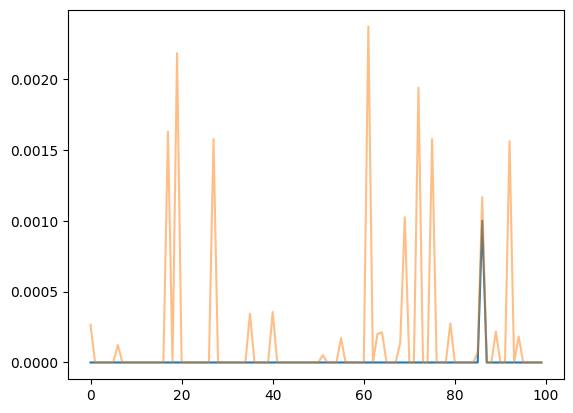

In [94]:
plt.plot(y_train[ :100])
plt.plot(y_pred[:100], alpha=0.5)

(array([233., 102.,  78.,  41.,  34.,  16.,   0.,   1.,   1.,   3.,   6.,
          3.,   0.,  11.,   1.,   5.,   1.,   3.,   0.,   4.,   5.,   6.,
          9.,   2.,   1.,   4.,   4.,   3.,   1.,   2.,   2.,   0.,   1.,
          7.,   6.,   2.,   6.,   0.,   9.,   8.,  10.,   9.,   5.,   0.,
          4.,   5.,   3.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   3.,
          4.,   0.,   1.,   0.,   1.,   2.,   1.,   0.,   2.,   0.,   0.,
          1.,   1.,   0.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   2.,
          3.,   1.,   1.,   4.,   0.,   0.,   3.,   2.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.001  , 0.00184, 0.00268, 0.00352, 0.00436, 0.0052 , 0.00604,
        0.00688, 0.00772, 0.00856, 0.0094 , 0.01024, 0.01108, 0.01192,
        0.01276, 0.0136 , 0.01444, 0.01528, 0.01612, 0.01696, 0.0178 ,
        0.01864, 0.01948, 0.02032, 0.02116, 0.022  , 0.02284, 0.02368,
        0.02452, 0.02536, 0.0262 ,

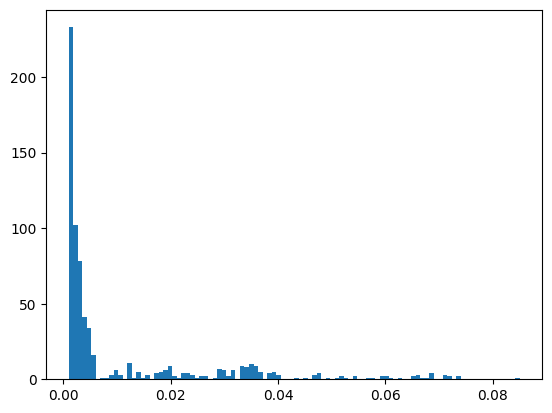

In [91]:
plt.hist(y[y>0], bins=100)

(array([1016.,  444.,  242.,   85.,   87.,   49.,   35.,   32.,   31.,
          38.,   23.,   36.,   48.,   25.,   40.,   82.,   31.,   67.,
          35.,   67.,   36.,   19.,   39.,   21.,   36.,   17.,   31.,
          16.,   33.,    0.,    6.,   12.,    0.,    0.,   26.,    0.,
          10.,    0.,   18.,   20.,    9.,    0.,    8.,   28.,    0.,
           9.,    0.,    0.,   21.,   14.,    0.,    0.,    0.,    0.,
           0.,    0.,   15.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           9.]),
 array([3.68229455e-05, 1.36943727e-04, 2.37064508e-04, 3.37185289e-04,
        4.37306071e-04, 5.37426852e-04, 6.37547633e-04, 7.37668415e-04,
        8.37789196e-04, 9.37909977e-04, 1.03803076e-03, 1.

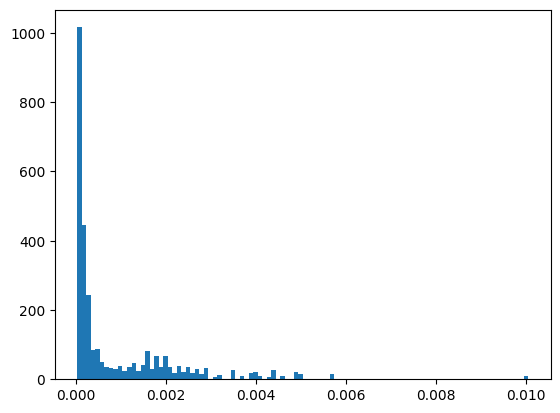

In [92]:
plt.hist(y_pred[y_pred>0], bins=100)